# Машинное обучение в бизнесе #

### Описание проекта ###

Нужно решить, где бурить новую скважину.

Шаги для выбора локации обычно такие:
* В избранном регионе собирают характеристики для скважин: качество нефти и объём её запасов;
* Строят модель для предсказания объёма запасов в новых скважинах;
* Выбирают скважины с самыми высокими оценками значений;
* Определяют регион с максимальной суммарной прибылью отобранных скважин.

Предоставлены пробы нефти в трёх регионах. Характеристики для каждой скважины в регионе уже известны. Нужно построить модель для определения региона, где добыча принесёт наибольшую прибыль, а также проанализировать возможную прибыль и риски техникой Bootstrap.

**Описание данных**

* id — уникальный идентификатор скважины;
* f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
* product — объём запасов в скважине (тыс. баррелей).

**Условия задачи:**
* Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
* При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
* Бюджет на разработку скважин в регионе — 10 млрд рублей.
* При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
* После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.
* Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.


## Обзор данных ##

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [2]:
try:
    df_0 = pd.read_csv('/datasets/geo_data_0.csv')
    df_1 = pd.read_csv('/datasets/geo_data_1.csv')
    df_2 = pd.read_csv('/datasets/geo_data_2.csv')
except:
    df_0 = pd.read_csv('geo_data_0.csv')
    df_1 = pd.read_csv('geo_data_1.csv')
    df_2 = pd.read_csv('geo_data_2.csv')
    
df_0.info()
df_0.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [3]:
df_1.info()
df_1.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [4]:
df_2.info()
df_2.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


У нас имеются 3 датасета с информацией по нефтяным скважинам в 3 регионах. Каждый датасет содержит по 100_000 строк и 5 столбцов. Пропуски в данных отсутсвуют. Целевым признаком для всех регионов является столбец `product`.

Посмотрим на распределение признаков, а также на их корреляцию.

,f0,f1,f2,product
f0,1.000000,-0.440723,-0.003153,0.143536
f1,-0.440723,1.000000,0.001724,-0.192356
f2,-0.003153,0.001724,1.000000,0.483663
product,0.143536,-0.192356,0.483663,1.000000


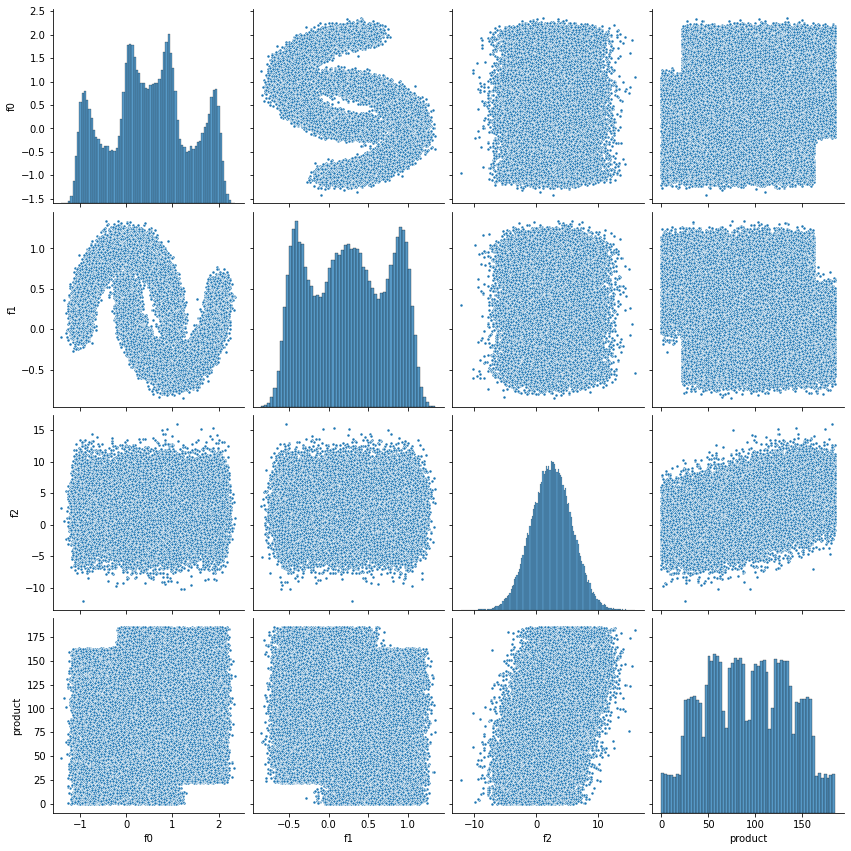

In [5]:
sns.pairplot(df_0, height=3, markers='.')
df_0.corr()

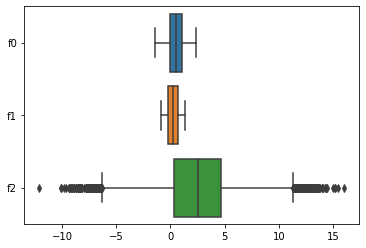

In [6]:
sns.boxplot(data=df_0[['f0', 'f1', 'f2']], orient='h');

In [7]:
df_0['product'].value_counts()

0.000000      1
30.141653     1
56.573577     1
50.182301     1
88.989990     1
             ..
146.560758    1
155.729658    1
27.829511     1
85.382946     1
154.424007    1
Name: product, Length: 100000, dtype: int64

Видно, что больше всего с таргетом коррелирует признак `f2`. Также можно увидеть, что признаки `f0` и `f1` имеют отрицательную корреляцию.

,f0,f1,f2,product
f0,1.000000,0.182287,-0.001777,-0.030491
f1,0.182287,1.000000,-0.002595,-0.010155
f2,-0.001777,-0.002595,1.000000,0.999397
product,-0.030491,-0.010155,0.999397,1.000000


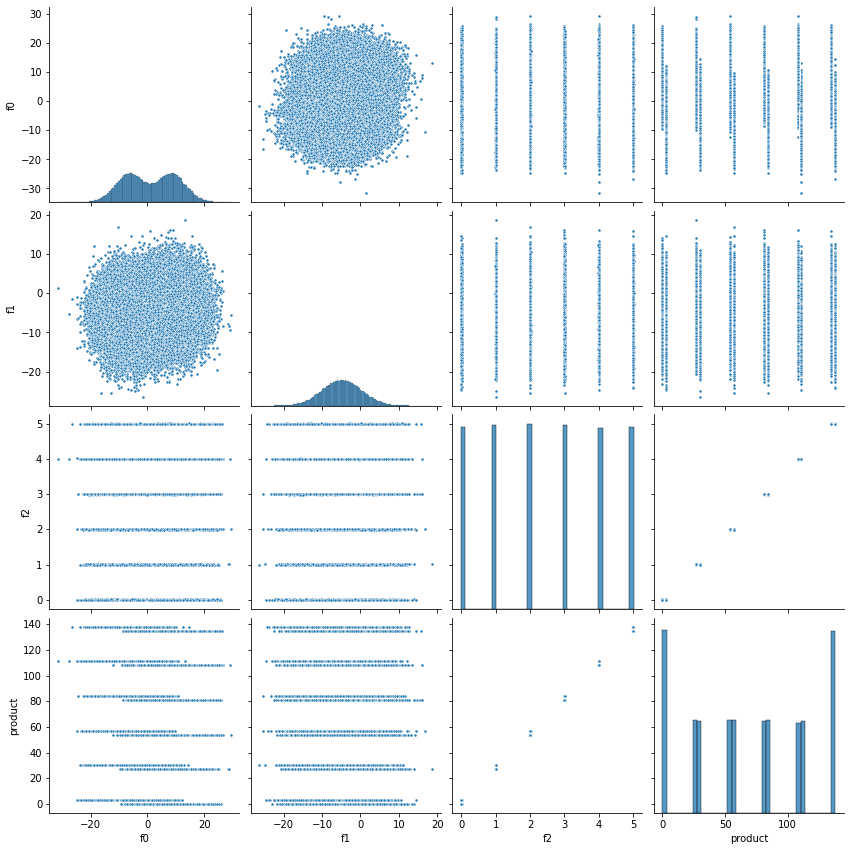

In [8]:
sns.pairplot(df_1, height=3, markers='.')
df_1.corr()

<AxesSubplot:>

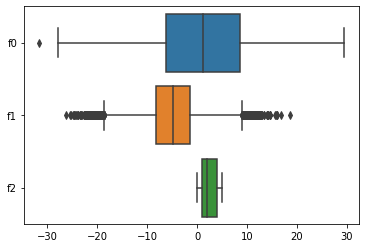

In [9]:
sns.boxplot(data=df_1[['f0', 'f1', 'f2']], orient='h')

In [10]:
df_1['product'].value_counts()

53.906522     8472
26.953261     8468
84.038886     8431
57.085625     8390
3.179103      8337
80.859783     8320
30.132364     8306
134.766305    8304
110.992147    8303
0.000000      8235
137.945408    8233
107.813044    8201
Name: product, dtype: int64

По данному датасету имеется очень сильная прямая корреляция признака `f2` и таргета - более 99%. Соответственно модель будет легко обучатся на этом признаке. Остальные признаки будут практически неважны. 

Кроме того, в отличие от остальных регионов, целевой признак `product` имеет всего 12 уникальных значений. Возможно, данные ранее были каким-то образом сгруппированы. 

,f0,f1,f2,product
f0,1.000000,0.000528,-0.000448,-0.001987
f1,0.000528,1.000000,0.000779,-0.001012
f2,-0.000448,0.000779,1.000000,0.445871
product,-0.001987,-0.001012,0.445871,1.000000


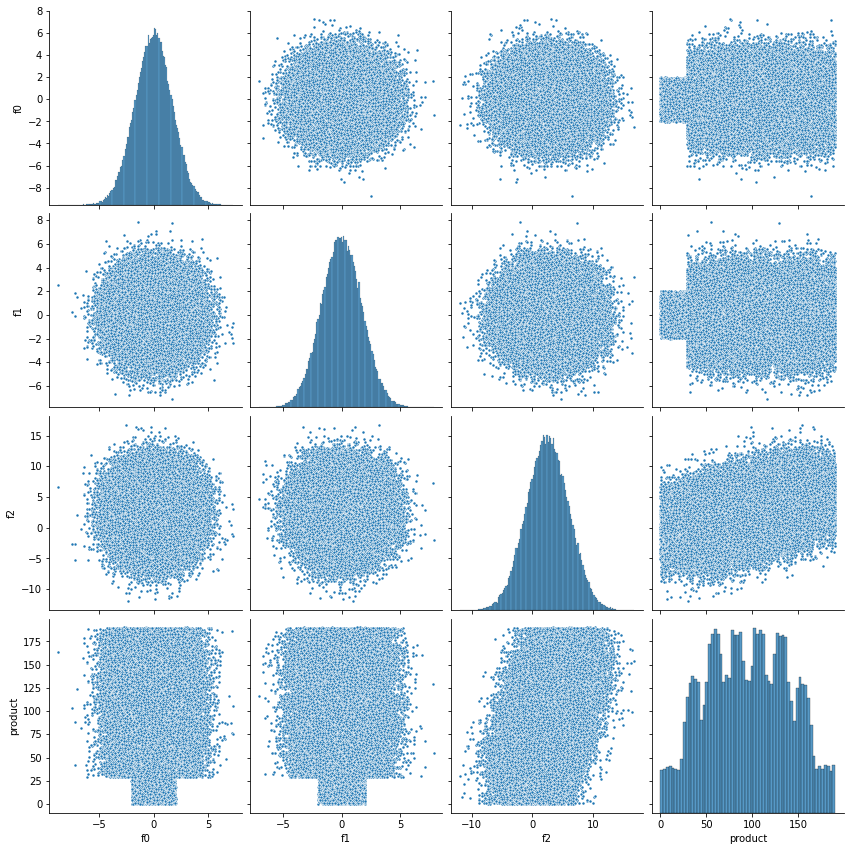

In [11]:
sns.pairplot(df_2, height=3, markers='.')
df_2.corr()

In [12]:
df_2['product'].value_counts()

0.000000      1
53.211205     1
37.811021     1
84.266951     1
38.939298     1
             ..
122.326832    1
34.629840     1
3.577922      1
0.937771      1
49.640390     1
Name: product, Length: 100000, dtype: int64

<AxesSubplot:>

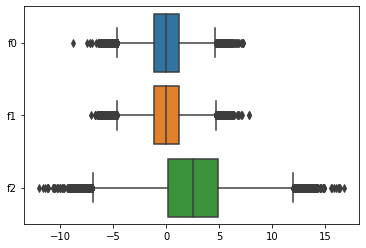

In [13]:
sns.boxplot(data=df_2[['f0', 'f1', 'f2']], orient='h')

В данном случае опять же наибольшее влияние на таргет имеет признак `f2`, однако его влияние гораздо меньше, чем во втором регионе.

В признаках опять же имеются выброс. Но т.к. все данные уже были обработаны до того, как попали к нам, а их значение не раскрывается, то удалять выбросы не будем, чтобы не потерять никакие данные. Так же, несмотря на то, что признаки `f1` и `f2` слабо коррелируют с таргетом удалять их нельзя. 

## Подготовка выборок и обучение модели 

Для каждого датасета выделим признак и таргет, а так же разделим их на обучающие и валидационные выборки.

Чтобы не делать это вручную для каждого отдельного датасета создадим функцию, которая на вход принимает список датасетов, а возвращает словари, в которых содержатся выборки.

In [14]:
state = np.random.RandomState(42)

def features_target_sample_split(df_list):
    features = {}
    target = {}
    features_train = {}
    features_valid = {}
    target_train = {}
    target_valid = {}

    for i in range(len(df_list)):

        features[i] = df_list[i][['f0', 'f1', 'f2']]
        target[i] = df_list[i][['product']]

        features_train[i], features_valid[i], target_train[i], target_valid[i] = train_test_split(
            features[i], target[i], test_size=0.25, random_state=state)   

    return features_train, features_valid, target_train, target_valid

df_list = [df_0, df_1, df_2]

features_train, features_valid, target_train, target_valid = features_target_sample_split(df_list)

for i in range(len(features_train)):
    print(f'df_{i}')
    print(features_train[i].shape, target_train[i].shape)
    print(features_valid[i].shape, target_valid[i].shape)
    print()

df_0
(75000, 3) (75000, 1)
(25000, 3) (25000, 1)

df_1
(75000, 3) (75000, 1)
(25000, 3) (25000, 1)

df_2
(75000, 3) (75000, 1)
(25000, 3) (25000, 1)



Теперь для каждого региона обучим модель и рассчитаем RMSE. Чтобы быть уверенными в адектватности работы модели дополнительно рассчитаем RMSE для константной модели.

In [15]:
model = LinearRegression(n_jobs=4)

predictions = {}
rmse_results = {}

for i in range(len(features_train)):
    model.fit(features_train[i], target_train[i])
    predictions[i] = model.predict(features_valid[i])
    rmse_results[i] = mean_squared_error(predictions[i], target_valid[i]) ** .5
    target_mean = target_valid[i]['product'].mean()
    
    const_pred = pd.Series(target_valid[i]['product'].mean(), index=target_valid[i].index)
    
    print(f'Регион df_{i}:')
    print(f'RMSE константной модели = {mean_squared_error(const_pred, target_valid[i]) ** .5 :.3f}')
    print(f'RMSE регрессии = {rmse_results[i] :.3f}')
    print(f'Предсказанный средний запас сырья = {predictions[i].mean() :.3f}')
    print(f'Реальный средний запас сырья для = {target_mean :.3f}')
    print()
    
    predictions[i] = pd.DataFrame(predictions[i], index=target_valid[i].index)


Регион df_0:
RMSE константной модели = 44.277
RMSE регрессии = 37.757
Предсказанный средний запас сырья = 92.399
Реальный средний запас сырья для = 92.326

Регион df_1:
RMSE константной модели = 45.935
RMSE регрессии = 0.890
Предсказанный средний запас сырья = 68.588
Реальный средний запас сырья для = 68.600

Регион df_2:
RMSE константной модели = 44.810
RMSE регрессии = 40.237
Предсказанный средний запас сырья = 95.092
Реальный средний запас сырья для = 95.035



Для второго региона показатель RMSE близок к нулю - это значит, что модель очень точно предсказывает запасы сырья в скважинах. Как и предпологалось ранее, это из-за того, что таргет сильно коррелирует с признаком `f2`.
Однако, для этого региона средний запас сырья значительно ниже, чем у двух других. 

В двух других RMSE линейной регрессии близок к RMSE константной модели - это значит, что качество модели довольное низкое. 
Хуже всего модель отработала для `df_2`, т.к. признаки `f0` и `f1` практически не влияют на целевой признак, а `f2` влияет слабее, чем в других регионах.

Тем не менее, средние предсказанные значения запасов довольно близки к реальным средним запасам. 

## Подготовка и расчет прибыли ##

### Подготовка к расчету ###

Для начала рассчитаем запас сырья в скважине, необходимый для безубыточной добычи.

In [16]:
BUDGET = 10 ** 10
WELLS = 200
UNIT_INCOME = 450000
value_per_well = BUDGET / WELLS / UNIT_INCOME
value_per_well

111.11111111111111

Видно, что для для безубыточной добычи все разрабатываемые скважины, должны иметь запасы более 111 тыс. баррелей сырья. Однако, средние показатели по всем регионам ниже этих значений. Это значит, что всегда будет вероятность, что при разработке новой скважины в ней будет недостаточно сырья.

Напишем функцию для поиска суммарной прибыли по заданному количеству скважин.

In [17]:
def find_profit(prediction, target, count):
 
    pred_sorted = prediction.sort_values(by=0, ascending=False)
    selected = target.loc[pred_sorted.index][:count]
    profit = selected.sum() * UNIT_INCOME - BUDGET
        
    return profit

Проверим работу функции.


In [18]:
for i in range(len(predictions)):
    profit = find_profit(predictions[i], target_valid[i]['product'], WELLS)
    print(f'Прибыль для региона df_{i}: {profit / BUDGET * 10 :.2f} млрд. рублей', end='\n\n')

Прибыль для региона df_0: 3.36 млрд. рублей

Прибыль для региона df_1: 2.42 млрд. рублей

Прибыль для региона df_2: 2.58 млрд. рублей



Если считать по 200 лучшим предсказаниям для каждого региона, то видно, что наибольшую прибыль можнно получить в первом регионе.

### Расчет рисков и прибыли для каждого региона ###

Для расчета прибыли и вероятности убытков применим Bootstrap.

In [19]:
for i in range(len(predictions)):
    values = []
    negative_values = []
    
    for j in range(1000):
        target_subsample = target_valid[i]['product'].sample(n=500, replace=False, random_state=state)
        preds_subsample = predictions[i].loc[target_subsample.index]
        profit = find_profit(preds_subsample, target_subsample, WELLS)
        values.append(profit)
        

    values = pd.Series(values)

    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    mean = values.mean()
    
    print(f'Регион df_{i}:')
    print(f'Средняя прибыль со скважины для региона: {mean / BUDGET * 10:.2f} млрд. рублей') 
    print(f'95%-ый доверительный интервал: {lower / BUDGET * 10 :.2f} - {upper / BUDGET * 10 :.2f} млрд. рублей')
    print(f'Риск получить отрицательную прибыль: {(values < 0).mean() :.2%}')
    print()

Регион df_0:
Средняя прибыль со скважины для региона: 0.40 млрд. рублей
95%-ый доверительный интервал: -0.14 - 0.91 млрд. рублей
Риск получить отрицательную прибыль: 7.00%

Регион df_1:
Средняя прибыль со скважины для региона: 0.43 млрд. рублей
95%-ый доверительный интервал: 0.05 - 0.80 млрд. рублей
Риск получить отрицательную прибыль: 1.50%

Регион df_2:
Средняя прибыль со скважины для региона: 0.33 млрд. рублей
95%-ый доверительный интервал: -0.21 - 0.87 млрд. рублей
Риск получить отрицательную прибыль: 10.50%



После расчета видно, что меньше всего процент убыточной разработки во втором регионе - всего 1.5%. Так же прибыль с одной скважины для этого же региона с 95% вероятностю будет от 30 до 820 миллионов рублей, что так же является лучшим показателем. Поэтому данный регион можно рекомендовать к разработке скважин.

## Общий вывод ##

В ходе работы были изучены данные о нефтяных месторождениях в 3 разных регионах.
1. Представленные данные не нуждались в предобработке. Анализ показал, что набор данных для вторго региона сильно отличаются от 2 других: столбцы `f2` и `product` имеют очень сильную корреляцию, и кроме того `product` имеет всего 12 уникальных значений. Из-за этого, модель на этих данных очень точно предсказывает целевой признак.
2. Далее данные были разбиты на обучающие и валидационные выборки. Для каждого региона были посчитаны средние запасы сырья в скважинах, а также RMSE. 
3. Последним этапом была расчитана средняя прибыль и риск убытков для каждого региона. Несмотря на то, что рассчитанные средние запасы сырья в скважинах и прибыль на лучших предсказаниях для второго региона были меньше других, показатель средней прибыли, у него значительно выше, а вероятность рисков ниже, чем у других регионов. Поэтому для разработки скважин рекомендуется **регион df_1**.

Тем не менее, стоит отметить, что связано с тем, что исходный датасет по данному региону отличается от других - данные лучше подготовлены для обучения линейной регрессии. Если бы данные были более похожи на другие регионы, результат исследования мог бы отличаться.
